In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
import cv2
from glob import glob
from tqdm import tqdm
from PIL import Image

# === Define paths ===
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO-t'
IMAGE_TRAIN_DIR = os.path.join(BASE_PATH, 'images/train')
IMAGE_TEST_DIR = os.path.join(BASE_PATH, 'images/test')
GT_MASK_DIR = os.path.join(BASE_PATH, 'GT')

YOLO4_LABEL_TRAIN = os.path.join(BASE_PATH, 'labels_yolo4/train')
YOLO4_LABEL_TEST = os.path.join(BASE_PATH, 'labels_yolo4/test')

os.makedirs(YOLO4_LABEL_TRAIN, exist_ok=True)
os.makedirs(YOLO4_LABEL_TEST, exist_ok=True)

# === Convert binary mask to YOLOv4 bounding boxes ===
def mask_to_yolo_bbox(mask_path, image_shape):
    mask = cv2.imread(mask_path, 0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)  # Ensure binary
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    h, w = image_shape
    annotations = []
    for contour in contours:
        x, y, bw, bh = cv2.boundingRect(contour)
        x_center = (x + bw / 2) / w
        y_center = (y + bh / 2) / h
        bw_norm = bw / w
        bh_norm = bh / h
        annotations.append(f"0 {x_center:.6f} {y_center:.6f} {bw_norm:.6f} {bh_norm:.6f}")
    return annotations

# === Process function for a given split ===
def process_split_bbox(image_dir, label_dir, max_images=20):
    print(f"\n Scanning: {image_dir}")
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    image_files = sorted(image_files)[:max_images]
    print(f"🖼️ Found {len(image_files)} images to process.")

    for img_path in tqdm(image_files):
        filename = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(GT_MASK_DIR, filename + '.png')

        if not os.path.exists(mask_path):
            print(f"[SKIP] No mask found for {filename}")
            continue

        with Image.open(img_path) as im:
            w, h = im.size

        yolo_labels = mask_to_yolo_bbox(mask_path, (h, w))

        if not yolo_labels:
            print(f"[EMPTY] No objects in mask for {filename}")
            continue

        label_file = os.path.join(label_dir, filename + '.txt')
        with open(label_file, 'w') as f:
            for line in yolo_labels:
                f.write(line + '\n')

        # Removed the print statement from the loop to avoid cluttering the output
        # print(f"[✅] Saved label for {filename}")

# === Run for 20 train and 20 test images ===
process_split_bbox(IMAGE_TRAIN_DIR, YOLO4_LABEL_TRAIN, max_images=20)
process_split_bbox(IMAGE_TEST_DIR, YOLO4_LABEL_TEST, max_images=20)

# === Confirm result ===
train_labels = glob(os.path.join(YOLO4_LABEL_TRAIN, '*.txt'))
test_labels = glob(os.path.join(YOLO4_LABEL_TEST, '*.txt'))

print(f"\n📄 Label files created:")
print(f"Train: {len(train_labels)}")
print(f"Test:  {len(test_labels)}")


 Scanning: /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO-t/images/train
🖼️ Found 20 images to process.


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]



 Scanning: /content/drive/MyDrive/Colab Notebooks/Dataset/CAMO-t/images/test
🖼️ Found 19 images to process.


100%|██████████| 19/19 [00:27<00:00,  1.45s/it]


📄 Label files created:
Train: 20
Test:  19


Create the necessary configuration files for your YOLOv4 model

In [18]:
import os

# === Create train.txt and test.txt ===
def create_list_file(image_dir, output_file):
    with open(output_file, 'w') as f:
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    f.write(os.path.join(root, file) + '\n')

create_list_file(IMAGE_TRAIN_DIR, os.path.join(BASE_PATH, 'train.txt'))
create_list_file(IMAGE_TEST_DIR, os.path.join(BASE_PATH, 'test.txt'))

# === Create obj.data ===
with open(os.path.join(BASE_PATH, 'obj.data'), 'w') as f:
    f.write('classes = 1\n')
    f.write(f'train = {os.path.join(BASE_PATH, "train.txt")}\n')
    f.write(f'valid = {os.path.join(BASE_PATH, "test.txt")}\n')
    f.write(f'names = {os.path.join(BASE_PATH, "obj.names")}\n')
    f.write(f'backup = {os.path.join(BASE_PATH, "backup/")}\n')

# === Create obj.names ===
with open(os.path.join(BASE_PATH, 'obj.names'), 'w') as f:
    f.write('object\n')

print("✅ YOLOv4 configuration files created successfully!")

✅ YOLOv4 configuration files created successfully!


Clone the Darknet Repository

In [20]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15903, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15903 (delta 0), reused 1 (delta 0), pack-reused 15900 (from 1)
Receiving objects: 100% (15903/15903), 14.43 MiB | 12.85 MiB/s, done.
Resolving deltas: 100% (10708/10708), done.


In [21]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: un

In [22]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

--2025-07-29 12:35:15--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/48bfe500-889d-11ea-819e-c4d182fcf0db?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-29T13%3A31%3A56Z&rscd=attachment%3B+filename%3Dyolov4.conv.137&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-29T12%3A31%3A05Z&ske=2025-07-29T13%3A31%3A56Z&sks=b&skv=2018-11-09&sig=8KkliPi2%2Ff3h7W78z6KDkftmlKRBZJ1Et1VyawZOUIo%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1Mzc5MjgxNSwibmJmIjoxNzUzNzkyNTE1LCJwYXRoIjoicmVsZWFzZWFzc2V0c

In [26]:
!./darknet detector train "/content/drive/MyDrive/Colab Notebooks/Dataset/CAMO-t/obj.data" "/content/darknet/cfg/yolov4-custom.cfg" "yolov4.conv.137" -dont_show -map

./darknet: error while loading shared libraries: libcuda.so.1: cannot open shared object file: No such file or directory


In [24]:
!sudo ln -s /usr/local/cuda/lib64/libcuda.so /usr/lib/libcuda.so.1

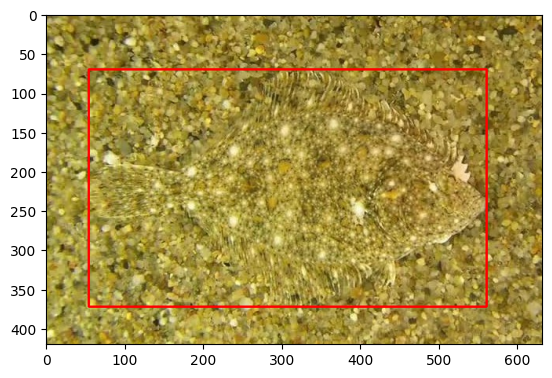

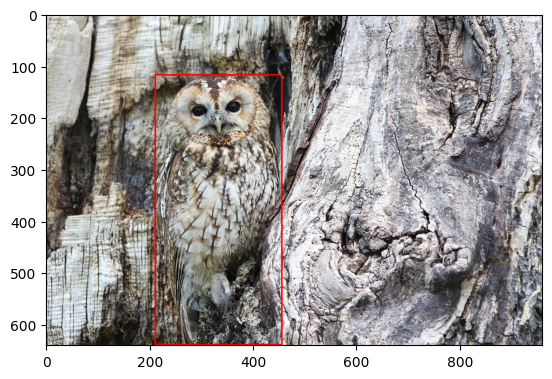

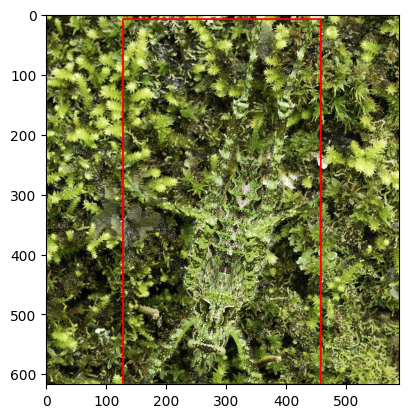

In [27]:
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Function to display images with bounding boxes
def show_image_with_bbox(img_path, Bbox_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(Bbox_path, 'r') as f:
        for line in f.readlines():
            label, x_center, y_center, width, height = [float(i) for i in line.split()]

            h, w, _ = img.shape
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img)
    plt.show()

# Get a list of test images and their corresponding labels
test_images = sorted(glob(os.path.join(IMAGE_TEST_DIR, '*.jpg')))
test_labels = sorted(glob(os.path.join(YOLO4_LABEL_TEST, '*.txt')))

# Visualize a few examples
for i in range(min(3, len(test_images))):
    show_image_with_bbox(test_images[i], test_labels[i])